# Covid 19 Waste Detection:

Sample Inference Notebook

In [1]:
import sys

import icevision
import matplotlib.pyplot as plt
from icedata.utils import load_model_weights_from_url
from icevision.all import *
from PIL import Image
from torchvision.transforms.functional import resize

## Helper Functions-

In [2]:
def py3round(number):
    """Unified rounding in all python versions."""
    if abs(round(number) - number) == 0.5:
        return int(2.0 * round(number / 2.0))

    return int(round(number))


def _func_max_size(height, width, max_size, func):
    scale = max_size / float(func(width, height))

    if scale != 1.0:
        height, width = tuple(py3round(dim * scale) for dim in (height, width))
    return height, width


def get_transform(tfms_list, t):
    for el in tfms_list:
        if t in str(type(el)):
            return el
    return None


def _get_size_without_padding(
    tfms_list, before_tfm_img, after_tfm_img
) -> Tuple[int, int]:
    height, width, _ = after_tfm_img.shape

    if get_transform(tfms_list, "Pad") is not None:
        after_pad_h, after_pad_w, _ = before_tfm_img.shape

        t = get_transform(tfms_list, "SmallestMaxSize")
        if t is not None:
            presize = t.max_size
            height, width = _func_max_size(after_pad_h, after_pad_w, presize, min)

        t = get_transform(tfms_list, "LongestMaxSize")
        if t is not None:
            size = t.max_size
            height, width = _func_max_size(after_pad_h, after_pad_w, size, max)

    return height, width

## Components

In [3]:
CLASS_MAP = ClassMap({"background": 0, "syringe": 1, "glove": 2, "mask": 3})
COLOR_MAP = {"background": (255,255,255), "syringe": (127,255,212), "glove": (154,205,50), "mask": (255,105,180)}
CLASS_MAP

<ClassMap: {'background': 0, 'syringe': 1, 'glove': 2, 'mask': 3}>

In [4]:
size = 512
model_type = models.ross.efficientdet
backbone   = model_type.backbones.d0(pretrained=False)
extra_args = {"img_size": size}


infer_model = efficientdet.model(backbone=backbone, num_classes=len(CLASS_MAP), **extra_args)

## Load Trained Model weights

In [6]:
WEIGHTS_URL = "https://github.com/benihime91/Covid-Waste-Detection/releases/download/v1.0/effecientdnet-b0-ver0.01-3VNfX.pth"
load_model_weights_from_url(infer_model, WEIGHTS_URL, map_location=torch.device("cpu"))

## Model Inference

In [7]:
def predict_image(image, fig=(12, 12)):
    tfms_list = [*tfms.A.resize_and_pad(size), tfms.A.Normalize()]
    valid_tfms = tfms.A.Adapter(tfms_list)

    image = [np.asanyarray(image)]
    infer_ds = Dataset.from_images(images=image, tfm=valid_tfms, class_map=CLASS_MAP)

    preds = model_type.predict(infer_model, infer_ds)
    show_preds(preds, figsize=fig)

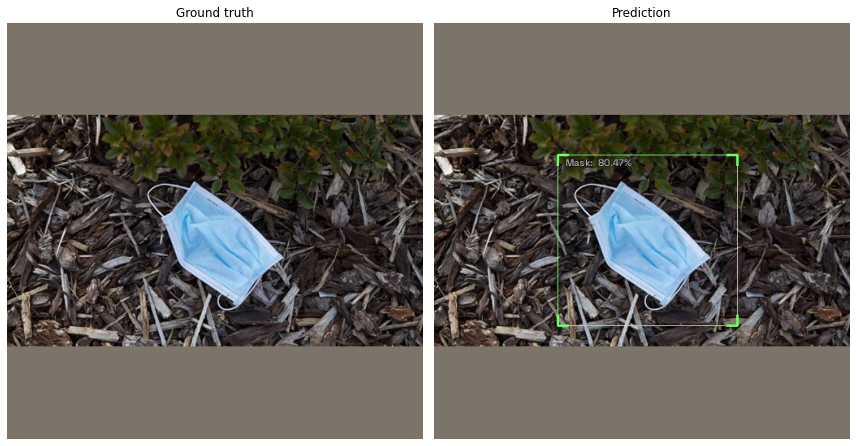

In [8]:
TEST = "/Users/ayushman/Downloads/mask-1-2.jpeg"
image = Image.open(TEST)
predict_image(image)

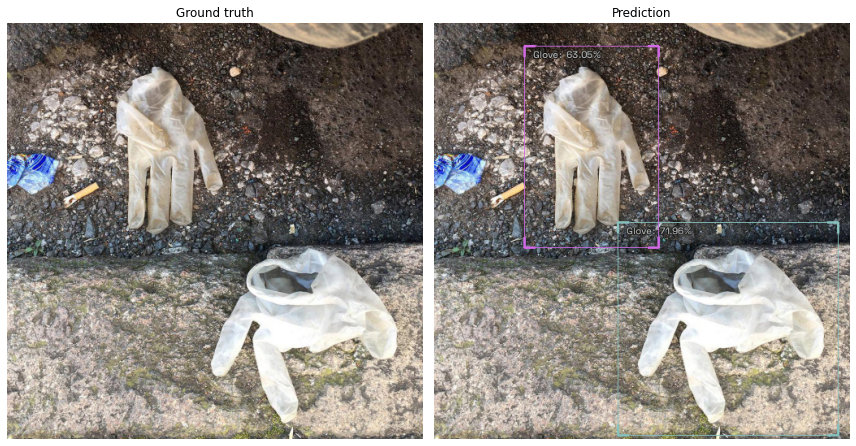

In [9]:
image = Image.open("/Users/ayushman/Downloads/_111639409_img_4590_jpg.rf.ec8628dfc2925d9d094df4b60772e6ac.jpg")
predict_image(image)

In [10]:
TRANSFORMS_LIST = [*tfms.A.resize_and_pad(size), tfms.A.Normalize()]
TRANSFORMS = tfms.A.Adapter(TRANSFORMS_LIST)


def prediction_handler(path, threshold=0.5, remove_padding=False):
    """
    Generate predictions for a single Image. 
    Adapted from :
    https://github.com/gabrielelanaro/ml-prototypes/prototypes/styletransfer/icevision_latex_lambda.py
    """
    image = Image.open(path).convert("RGB")
    print(f"Original image size: {image.size}")
    image = [np.asarray(image)]
    
    infer_ds = Dataset.from_images(images=image, tfm=TRANSFORMS, class_map=CLASS_MAP)
    
    infer_dl = model_type.infer_dl(infer_ds, batch_size=1)
    x, sample = first(infer_dl)
    print(f"Size after pre-processing :{str(x[0].shape)}")

    preds = model_type.predict(infer_model, infer_ds, detection_threshold=threshold)
    img = draw_pred(preds[0], denormalize_fn=denormalize_imagenet, color_map=COLOR_MAP)
    img = np.uint8(img)
    
    if remove_padding:
        img_h, img_w = _get_size_without_padding([TRANSFORMS_LIST], image[0], img)
        p = int(min(img_h,img_w)*0.1)
        
        if img_h < img_w:
            pad = (img_w-img_h)//2
            img = img[(pad-p):(img_h+pad+p),:,:]
        
        else:
            pad = (img_h-img_w)//2
            img = img[:,(pad-p):(img_w+pad+p),:]
    
    img = Image.fromarray(img)
    return img

In [11]:
image = prediction_handler(TEST, remove_padding=False)

Original image size: (759, 422)
Size after pre-processing :torch.Size([1, 3, 512, 512])


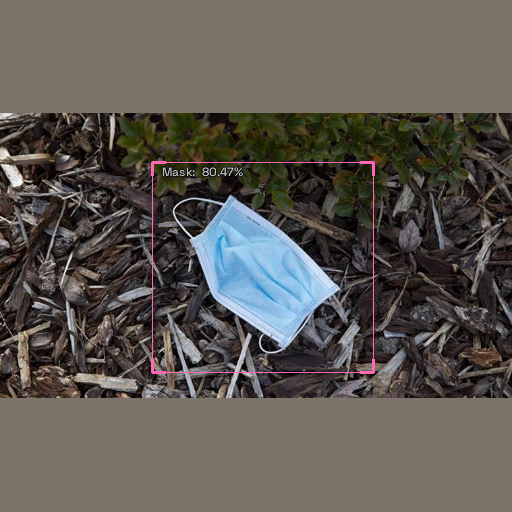

In [12]:
image

Original image size: (1024, 1024)
Size after pre-processing :torch.Size([1, 3, 512, 512])


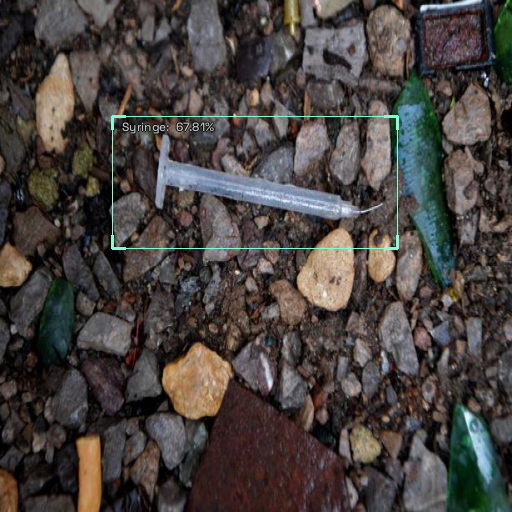

In [13]:
PATH = '/Users/ayushman/Desktop/Datasets/pascal-voc-waste-covid-19/test/0_JMP_SWA_281020_drug_hotspots_057_JPG_jpg.rf.ce74c0289eaa64647c9cd09164bfea55.jpg'
prediction_handler(PATH)

Original image size: (1024, 1024)
Size after pre-processing :torch.Size([1, 3, 512, 512])


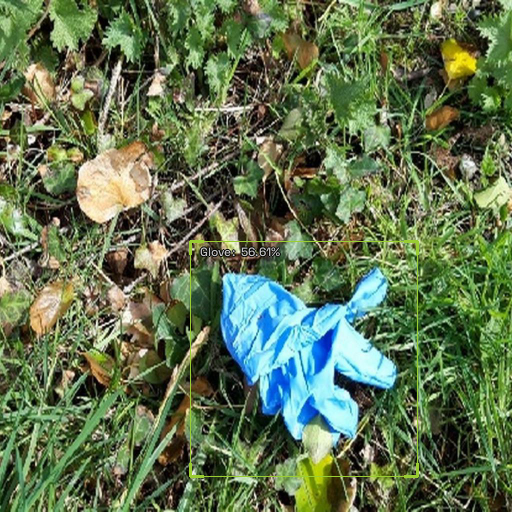

In [14]:
PATH = '/Users/ayushman/Desktop/Datasets/pascal-voc-waste-covid-19/test/0_SNR_GALN_080420-gloves-1_jpg.rf.df90e4a3cb7f9ab0c06ffa72251bbb13.jpg'
prediction_handler(PATH)

In [15]:
PATH = '/Users/ayushman/Desktop/Datasets/pascal-voc-waste-covid-19/test/2102856-1512072984_jpg.rf.9c52012751f7f0bd451311e566ca09e3.jpg'
image = prediction_handler(PATH, threshold=0.4)

Original image size: (1024, 1024)
Size after pre-processing :torch.Size([1, 3, 512, 512])


In [16]:
image.save('TEST_IMAGE.jpeg')

Original image size: (1024, 1024)
Size after pre-processing :torch.Size([1, 3, 512, 512])


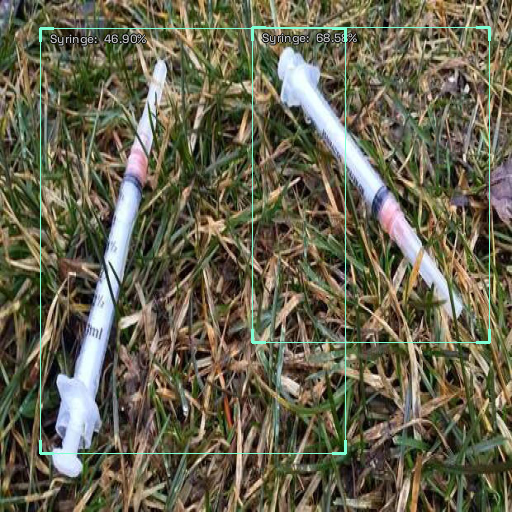

In [17]:
PATH = '/Users/ayushman/Desktop/Datasets/pascal-voc-waste-covid-19/test/image_jpg.rf.cb8e833bc344d6e91afafd9baeca5ed5.jpg'
prediction_handler(PATH, threshold=0.4)